# Application on HAL data

In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import seaborn as sns
import pandas as pd
import json
from statsmodels.graphics.tsaplots import plot_acf
from math import exp
from os import listdir
from os.path import isfile, join, splitext, basename
from sklearn.linear_model import LinearRegression
import networkx as nx
import random
import corner
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy import stats
from pandas.plotting import autocorrelation_plot, bootstrap_plot
from pathlib import Path
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import json

In [2]:
def read_raw_traces(path):
    with open(path, 'r') as file:
        reader = csv.reader(file)
        raw_data = list()
        try:
            for row in reader:
                raw_data.append([float(r) for r in row])
        except ValueError:
            print("error", row)
    data_trans = np.array(raw_data).transpose()
    return data_trans

def extract_posterior_dist(path, burn_in=0, by=1):
    data_trans = read_raw_traces(path)
    data_frame = pd.DataFrame({r'$\theta_{11}$': [b for b in data_trans[0][burn_in::by]],
                               r'$\theta_{12}$': [b for b in data_trans[1][burn_in::by]],
                               r'$\theta_{22}$': [b for b in data_trans[2][burn_in::by]]})
    return data_frame

def print_config(data):
        if not isinstance(data, list):
            for k, v in data.items():
                if k != 'posteriors':
                    print("{} => {}".format(k, v))

def summary(data):
    col_names = data.columns.values
    for i in [25,50,75]:
        print("========== Q{} ==========".format(i))
        for _, param_name in np.ndenumerate(col_names):
            q = np.percentile(data[param_name], i)
            print("Q{} for {} parameter {}".format(i, param_name, q))
    for _, param_name in np.ndenumerate(col_names):
            mean = np.mean(data[param_name], i)
            print("mean for {} parameter {}".format(param_name, mean))
        
    
    
def plot_marginals(data_abc, burn_in=0, by=1, title=None):
    
    col_names = data_abc.columns.values
    
    fig, axs = plt.subplots(len(col_names), 2, figsize=(14,15))
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for idx, param_name in np.ndenumerate(col_names):
        i = idx[0]
        # Sample parameter
        params = data_abc[param_name].tolist()[burn_in::by]

        # Distribution
        sns.distplot(params, axlabel="{} distribution ABC".format(param_name), ax=axs[i, 0])

        # Path
        axs[i, 1].plot(range(len(params)), params)
        axs[i, 1].set(xlabel='iterations', ylabel=r'{} parameter ABC'.format(param_name))


def autocor(data_abc, burn_in=0, by=1):

    col_names = data_abc.columns.values
    fig, axs = plt.subplots(len(col_names), 1, sharex='col', sharey='row', figsize=(14,21)) 
    
    for idx, param_name in np.ndenumerate(col_names):
        i = idx[0]
        params = data_abc[param_name].tolist()[burn_in::by]
    
        plot_acf(params, ax=axs[i])
        axs[i].set_title("Autocorrelation for {} parameter".format(param_name))

def display(dataset,  prefix=""):
    """Creates a fil displaying a summary of the model

    Arguments:
        results {List[GraphWrapper)] -- instance of the graph
                                        for each iteration
        summary_fct {fonction} -- function returning a summary dict
        title {str} -- Figure's title

    Keyword Arguments:
        prefix {str} -- filen (default: {""})
    """
    """
    Displays five different charts

    Arguments:
        results {[type]} - - [description]

    Keyword Arguments:
        prefix {str} - - [description](default: {""})
    """

    fig = plt.figure(figsize=(10, 10))

    for idx, label in enumerate(dataset):
        ax = plt.subplot(len(dataset), 1, idx + 1)
        ax.plot(dataset[label], label='Sample value')
        ax.plot(cumul_avg(dataset[label]), label='Cumulative average')
        ax.set_ylabel(label)

    plt.legend()
    plt.xlabel("Iterations")

    plt.subplots_adjust(hspace=0.4)
    plt.suptitle('Dynamic of the simulation')

def cumul_avg(tab):
    """Given a list of computable values (int/float)
    computes the corresponding list of moving average
    (cumulative average)

    Arguments:
        tab {List[int]} -- List of observed values

    Returns:
        {List[int]} -- Corresponding list of moving average
    """

    res = list()
    res = np.cumsum(tab) / np.arange(1, len(tab) + 1)
    #for i in range(1, len(tab)):
    #    cum_avg = sum(tab[0:i]) / (i + 1)
    #    res.append(cum_avg)

    return res


In [3]:
OUTPUT_TABLES = Path('./outputs/tables/')
OUTPUT_FIGS = Path('./outputs/figures/journal_paper/')
KEYS = [r'$\theta_{11}$', r'$\theta_{12}$', r'$\theta_{22}$']
BURNIN = 2000
BY = 1000

## Extract data
> Extract data from output files (records) of ABC Shadow

> Dependency : `files` (list of paths toward the files)

> Output : `data: dict[team_name:string, post_dict:dict]`, `obs: dict[team_name:string, [sufficient_stat, size]]`

In [4]:
RECORDS_DIR = './assets/teams_test/'
pattern = "*csv"
p = Path(RECORDS_DIR)
files = list(p.glob(pattern))
files = sorted(files, key=lambda x: basename(x))
files_r = [str(f) for f in files]

In [5]:
config_files = list(p.glob("*txt"))
config_files = sorted(config_files, key=lambda x: basename(x))
sizes = dict()
y_obs = dict()

for conf in config_files:
    filename = splitext(conf.name)[0].split('_')[0]
    with open(conf) as sizes_file:
        lines = sizes_file.readlines()
    for l in lines:
        if l.startswith("size"):
            splitted_line = l.replace(" ", "").split(":")[-1].rstrip().split(',')
            sizes[filename] = [int(splitted_line[0]), int(splitted_line[1])]
        elif l.startswith("y_obs"):
            splitted_line = l.replace(" ", "").split(":")[-1].rstrip().split(',')
            y_obs[filename] = [int(splitted_line[0]), int(splitted_line[1]), int(splitted_line[2])]

In [6]:
data = dict()
map_data = dict()
obs = dict()
by = 10
for f in files:
    filename = splitext(f.name)[0].split('_')[0]
    d = extract_posterior_dist(f, burn_in=BURNIN, by=BY)
    data[filename] = d

## Compute de MAP of each postrior distributions

In [7]:
%load_ext rpy2.ipython
%load_ext rmagic

R[write to console]: Pendant le démarrage - 
R[write to console]: Warning messages:

R[write to console]: 1: Setting LC_COLLATE failed, using "C" 

R[write to console]: 2: Setting LC_TIME failed, using "C" 

R[write to console]: 3: Setting LC_MESSAGES failed, using "C" 

R[write to console]: 4: Setting LC_MONETARY failed, using "C" 

/usr/local/lib/python3.7/site-packages/IPython/extensions/rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


> author of the code in the cell below: Radu Stoica

In [8]:
%%R -i files_r -o df_sum
library("rjson")
library("stringr")
K = 1
by = 100
burnin = 2000
df_sum <- data.frame(matrix(ncol =9, nrow = 0))
for (f in files_r){
  posteriors <- read.csv(f,header=FALSE)
  theta01 <-c()
  theta02 <-c()
  theta12 <-c()
  filename <- unlist(strsplit(tail(unlist(strsplit(f, '/')),1), '-'))[1]
  filename <- str_replace(filename, 'traces.csv', '')
  filename <- str_replace(filename, '_', '')
  theta01 <-  as.matrix(posteriors[1])
  theta02 <-  as.matrix(posteriors[2])
  theta12 <-  as.matrix(posteriors[3])
  theta01 <- theta01[seq(burnin,length(theta01),by)]
  theta02 <- theta02[seq(burnin,length(theta02),by)]
  theta12 <- theta12[seq(burnin,length(theta12),by)]
  #par(mfrow=c(2,3), main="Test")
  #plot(theta01,theta02,type="l",col="blue")
  #plot(theta01,theta12,type="l",col="blue")
  #plot(theta12,theta01,type="l",col="blue")
  #plot(theta01,type="l",col="blue",main="theta_01",xlab="",ylab="")
  #plot(theta02,type="l",col="blue",main="theta_02",xlab="",ylab="")
  #plot(theta12,type="l",col="blue",main="theta_03",xlab="",ylab="")
  dbeta1=density(theta01,kernel="epanechnikov")
  pbeta1=which.max(dbeta1$y)
  dbeta2=density(theta02,kernel="epanechnikov")
  pbeta2=which.max(dbeta2$y)
  dgamma=density(theta12,kernel="epanechnikov")
  pgamma=which.max(dgamma$y)
  df_sum[filename,] <- round(c(mean(theta01), quantile(theta01,0.5), dbeta1$x[pbeta1], mean(theta02), quantile(theta02,0.5), dbeta2$x[pbeta2], mean(theta12), quantile(theta12,0.5), dgamma$x[pgamma]), 6)
}

### Summary
> mean, Q50 and MAP for each parameter $\theta_{01}$, $\theta_{02}$, $\theta_{12}$ of all posteriors

In [9]:
df_sum.columns = [r'mean $\theta_{11}$', r'Q50 $\theta_{11}$', r'MAP $\theta_{11}$', r'mean $\theta_{12}$', r'Q50 $\theta_{12}$', r'MAP $\theta_{12}$', r'mean $\theta_{22}$', r'Q50 $\theta_{22}$', r'MAP $\theta_{22}$']

#df_sum.to_latex(OUTPUT_TABLES / 'summary_table_full.tex', encoding='utf-8', escape=False)
#df_sum_chunk1 = pd.DataFrame(df_sum, columns=[r'mean $\theta_{11}$', r'Q50 $\theta_{11}$', r'MAP $\theta_{11}$', r'mean $\theta_{12}$', r'Q50 $\theta_{12}$', r'MAP $\theta_{12}$'])
#df_sum_chunk1 = df_sum_chunk1.sort_values(by=[r'Q50 $\theta_{11}$'])
#df_sum_chunk1.to_latex(OUTPUT_TABLES / 'summary_table.tex', encoding='utf-8', escape=False)

#df_sum_chunk2 = pd.DataFrame(df_sum, columns=[r'mean $\theta_{22}$', r'Q50 $\theta_{22}$', r'MAP $\theta_{22}$'])
#df_sum_chunk2 = df_sum_chunk2.sort_values(by=[r'Q50 $\theta_{22}$'])
#df_sum_chunk2.to_latex(OUTPUT_TABLES / 'summary_table2.tex', encoding='utf-8', escape=False)
df_sum

,mean $\theta_{11}$,Q50 $\theta_{11}$,MAP $\theta_{11}$,mean $\theta_{12}$,Q50 $\theta_{12}$,MAP $\theta_{12}$,mean $\theta_{22}$,Q50 $\theta_{22}$,MAP $\theta_{22}$
BISCUIT,0.034645,0.056201,0.090716,-0.354889,-0.351304,-0.344692,-0.242431,-0.238684,-0.233961
CAPSID,0.101930,0.108264,0.118235,-0.127052,-0.128134,-0.131475,-0.135523,-0.134175,-0.128219
CARAMBA,-0.233394,-0.142432,0.049658,-0.957416,-0.920197,-0.881931,-1.122636,-1.092625,-0.967477
CARTE,0.073351,0.135571,0.244649,-0.364307,-0.354686,-0.335729,-0.219617,-0.212510,-0.197600
COAST,-0.072099,-0.063363,-0.045808,-0.366601,-0.367292,-0.360861,-0.246148,-0.237269,-0.220930
GAMBLE,-0.999697,-0.945988,-0.956321,0.075686,0.066205,0.042198,-0.152664,-0.149132,-0.140427
KIWI,-0.101770,0.000728,0.202198,-0.631764,-0.594769,-0.525821,-0.363616,-0.353656,-0.334875
MAIA,-0.109061,-0.108024,-0.105327,-0.934294,-0.922809,-0.887235,-0.176184,-0.160838,-0.130308
MOSEL,-0.261677,-0.165034,0.065593,-0.396747,-0.387528,-0.372064,-0.236376,-0.232612,-0.229694
NEUROSYS,-0.094323,-0.073407,-0.020220,-0.077016,-0.082784,-0.086297,-0.165134,-0.161836,-0.152721


### Save the MAPs in a json file in `maps.json`$^*$
> Save the MAPs in a json file. The `maps.json` will be afterward the input of `sim_from_map.py`

> Dependencies: `df_sum`, `obs`



> Format of `map.json`:

```json
{
    "team_id": {"theta": [map_theta11, map_theta12, map_theta22],
               "size": [in_size, out_size]}, // size of the observed graph
    ...
}
```

In [10]:
sum_dict = df_sum.to_dict()
map_file = dict()
for k, map01, map02, map12 in zip(sum_dict[r'mean $\theta_{11}$'].keys(), sum_dict[r'MAP $\theta_{11}$'].values(), sum_dict[r'MAP $\theta_{12}$'].values(), sum_dict[r'MAP $\theta_{22}$'].values()):
    map_file[k] = dict()
    map_file[k]["theta"] = map01, map02, map12
    map_file[k]["size"] = sizes[k]

with open('maps_journal.json', 'w') as output:
    json.dump(map_file, output)

map_dict = {k: v["theta"] for k, v in map_file.items()}
df_map = pd.DataFrame.from_dict(map_dict, orient="index")

In [11]:
post_sim_dir = "./assets/sim_from_map/NG/"
txt_pattern = "*txt"
by=100
post_sim_path = Path(post_sim_dir)
files = list(post_sim_path.glob(txt_pattern))
files = sorted(files, key=lambda x: basename(x))
for f in files:
    filename = splitext(f.name)[0].split('-')[0].replace('_', ' ')
    print(filename, obs[filename])
    with open(f, 'r') as file:
        reader = csv.reader(file,delimiter=' ')
        raw_data = list()
        for row in reader:
            raw_data.append([float(r) for r in row])
        data_trans = np.array(raw_data).transpose()
        data = dict()
        data[r"$t_{11}(y)$"] = data_trans[0][1::by]
        data[r"$t_{12}(y)$"] = data_trans[1][1::by] 
        data[r"$t_{22}(y)$"] = data_trans[2][1::by]
        print("t11(t) =  ", np.mean( data[r"$t_{11}(y)$"]))
        print("t12(t) =  ", np.mean( data[r"$t_{12}(y)$"]))
        print("t22(t) =  ", np.mean( data[r"$t_{22}(y)$"]))
        display(data, 'MH Potts')
        plt.show()

### Shape obs vectors
> Dependency : `obs`

> Output : `df_obs: Dataframe` `df_obs_fomated: Dataframe`

In [12]:
obs = dict()
for k, v in y_obs.items():
    obs[k] = [*v , *sizes[k]]
df_obs = pd.DataFrame.from_dict(obs, orient='index')

#### Save to latex

In [13]:
df_obs_formated = df_obs.copy()
df_obs_formated.columns = [r"$t_{11}$", r"$t_{12}$", r"$t_{22}$", "LORIA members", "External collaborators"]
df_obs_formated.to_latex(OUTPUT_TABLES / 'sufficient_stats.tex', encoding='utf-8', escape=False)
df_obs_formated

,$t_{11}$,$t_{12}$,$t_{22}$,LORIA members,External collaborators
BISCUIT,18,36,86,12,17
CAPSID,104,273,268,13,30
CARAMBA,3,4,5,7,9
CARTE,6,16,38,7,12
COAST,55,70,39,17,10
GAMBLE,7,95,204,8,26
KIWI,3,6,27,7,12
LARSEN,212,270,172,25,17
MADYNES,153,195,175,23,33
MAIA,234,18,17,25,8


In [14]:
internal = list()
external = list()
for s in sizes.values():
    internal.append(s[0])
    external.append(s[1])

data_sizes = pd.DataFrame({"Mean" : [np.round(np.mean(internal),2), np.round(np.mean(external),2)], 
                           "Median" : [np.round(np.median(internal),2), np.round(np.median(external),2)], 
                           "Standard deviation" : [np.round(np.std(internal),2), np.round(np.std(external),2)]})
data_sizes.index = ['Number of LORIA\'s members', 'Number of external collaborators']
data_sizes.to_latex(OUTPUT_TABLES / 'sizes.tex', encoding='utf-8', escape=False)
data_sizes

,Mean,Median,Standard deviation
Number of LORIA's members,14.82,13.0,7.38
Number of external collaborators,24.91,17.0,17.51


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


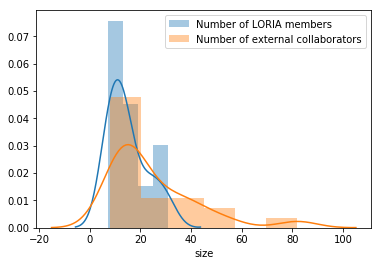

In [15]:
sns.distplot(internal, axlabel ='size', label='Number of LORIA members')
sns.distplot(external, label='Number of external collaborators')
plt.legend()

#### Compute the MAP
> Compute the MAP for each posterior in `data`

> Dependency : `data`

## Plot the posteriors (Box plots)

In [16]:
data.keys()

dict_keys(['BISCUIT', 'CAPSID', 'CARAMBA', 'CARTE', 'COAST', 'GAMBLE', 'KIWI', 'LARSEN', 'MADYNES', 'MAIA', 'MOSEL', 'MULTISPEECH', 'NEUROSYS', 'ORPAILLEUR', 'PAROLE', 'PESTO', 'RESIST', 'SEMAGRAMME', 'SIMBIOT', 'SMarT', 'SYNALP', 'VERIDIS'])

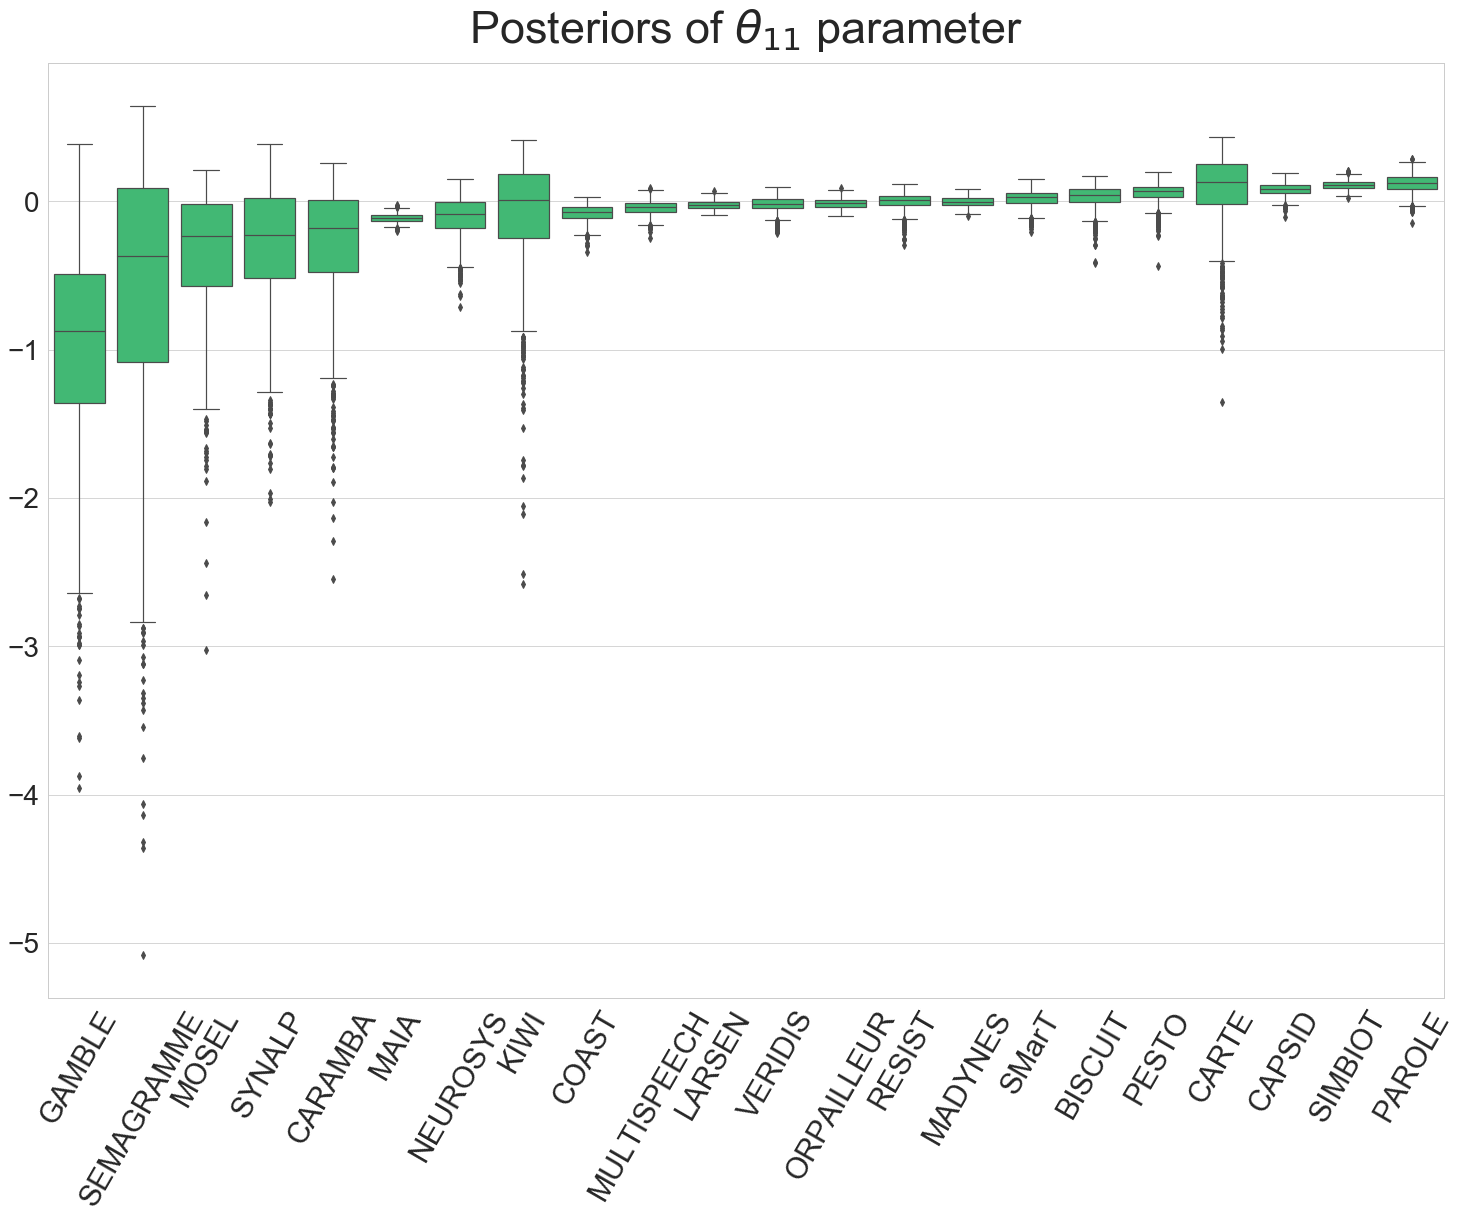

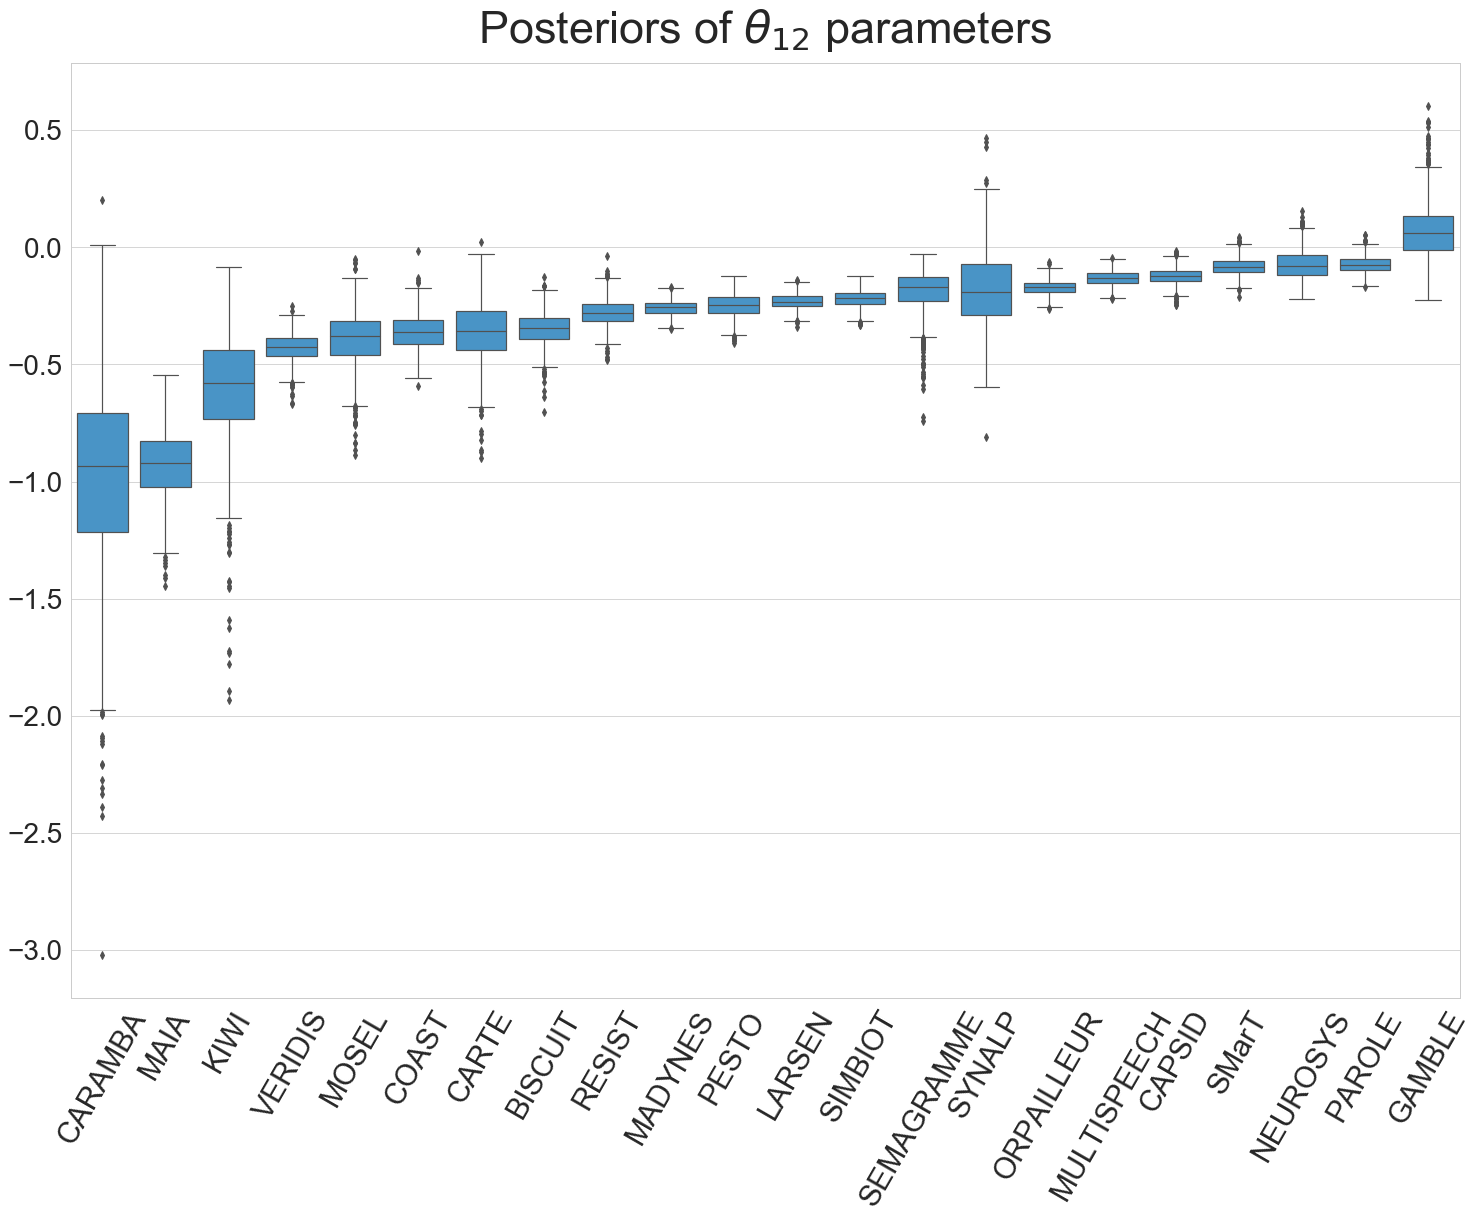

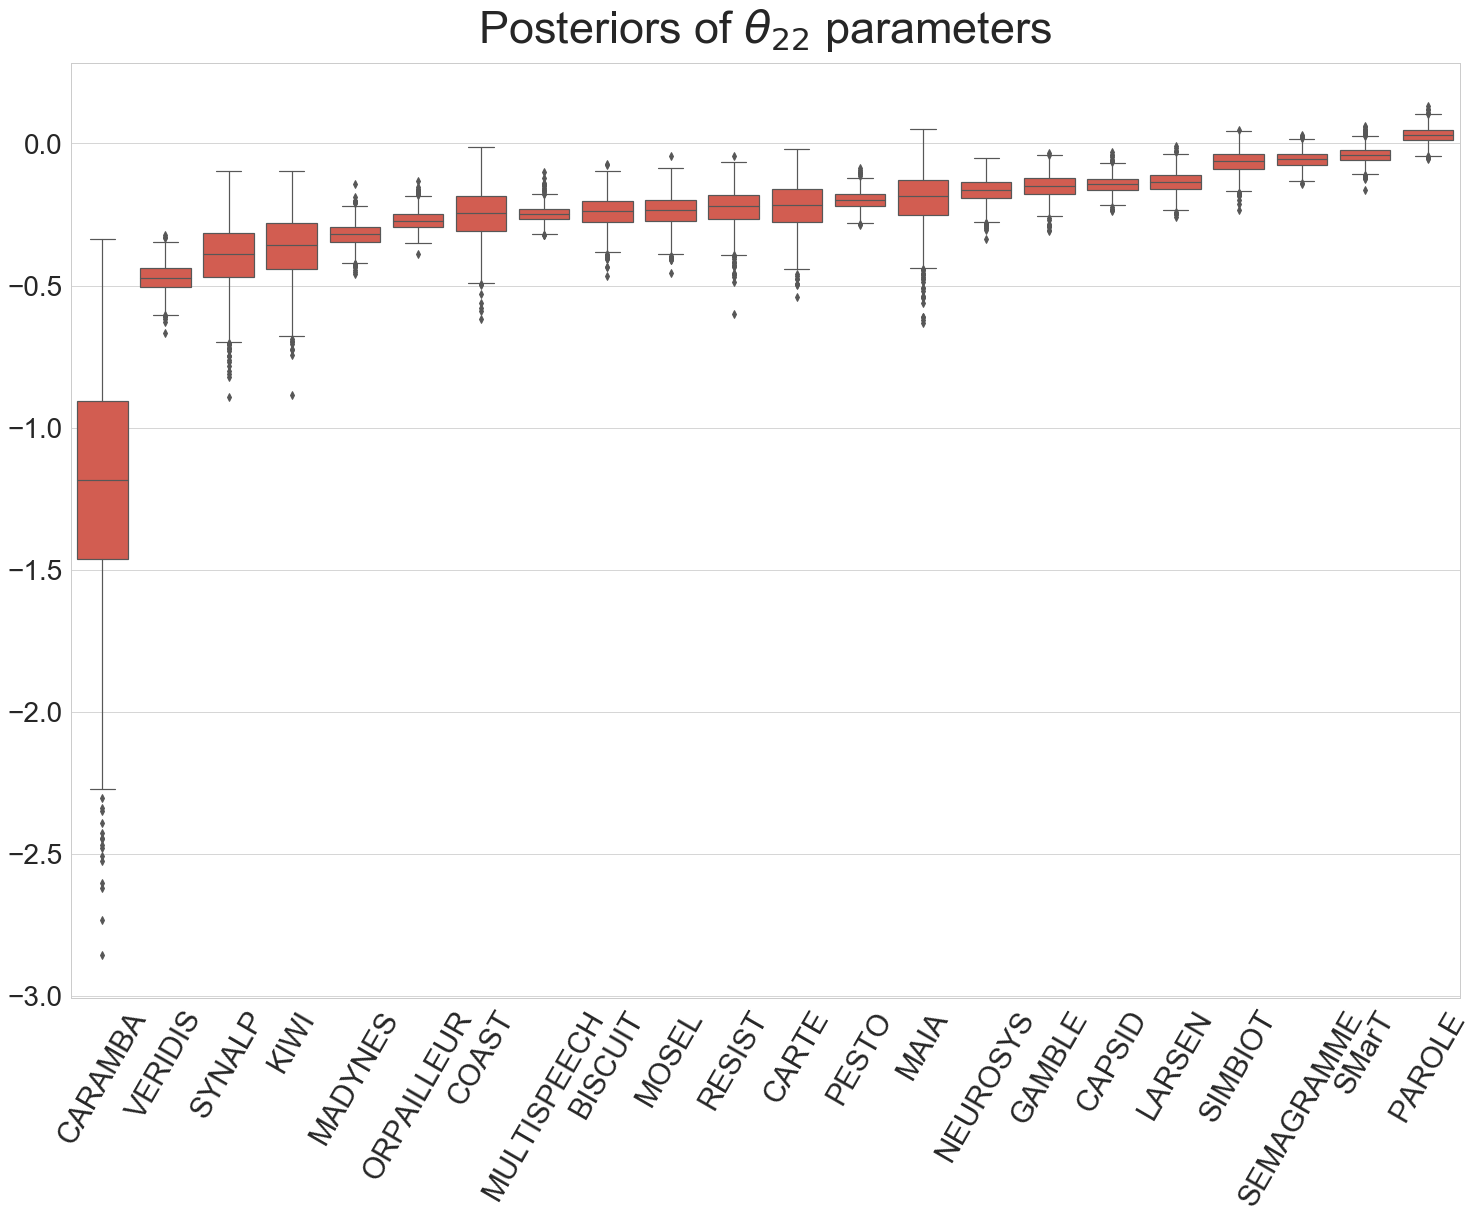

In [17]:
colors = ["#2ecc71", "#3498db", "#e74c3c"]
titles = [r'Posteriors of $\theta_{11}$ parameter', r'Posteriors of $\theta_{12}$ parameters', r'Posteriors of $\theta_{22}$ parameters']
sns.set_style("white")
sns.set_context("paper")
sns.set_style("whitegrid")
# For each parameter
for i, key in enumerate(KEYS):
    fig, ax = plt.subplots(figsize=(20,15))
    dict_posteriors = {t:d[key] for t, d in data.items()}
    order = sorted(dict_posteriors.keys(), key=lambda k: np.mean(dict_posteriors[k]))
    df_posteriors = pd.DataFrame.from_dict(dict_posteriors)

    box_plot = sns.boxplot(ax=ax, data=df_posteriors, color= colors[i], order=order)
    ax.set_title(titles[i], fontsize=45, pad=20)
    box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=60)
    plt.tight_layout()
    plt.tick_params(axis='x', labelsize=30)
    plt.tick_params(axis='y', labelsize=28)
    plt.savefig(OUTPUT_FIGS / f'posteriors_by_team{i}.pdf', bbox_inches='tight')
    plt.savefig(OUTPUT_FIGS / f'posteriors_by_team{i}.png', transparent=True, bbox_inches='tight')    #plt.show()

## Compute the asymptotics
> author of the code in the cell below: Radu Stoica

In [18]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [39]:
%%R error.stat.area = function(name.file,data.est){
    # ... reading the file of sufficient statistics
    data.area = read.table(name.file,sep = ",", header=F)

    # ... burning-in : drop-on the first values,
    # if exact simulation is used there is no need for burning-in ...
    pos=seq(from=1,nrow(data.area),1)

    nsamples=length(pos);

    beta1=data.area[pos,1]
    beta2=data.area[pos,2]
    beta3=data.area[pos,3]
    
    mnbeta1=cumsum(beta1)/(1:nsamples)
    mnbeta2=cumsum(beta2)/(1:nsamples)
    mnbeta3=cumsum(beta3)/(1:nsamples)

    esp.stat=c(mean(beta1),mean(beta2), mean(beta3))
    #print(esp.stat)
    grad=data.est[1:3]-esp.stat
    mat1=matrix(esp.stat,nrow=3,ncol=1)
    mat2=mat1%*%t(mat1)
    #print(mat2)
    mat3=matrix(0,nrow=3,ncol=3)

    for(i in 1 : nsamples)
    {
        stat.temp = c(beta1[i],beta2[i], beta3[i])
        temp=matrix(stat.temp,nrow=3,ncol=1)
        mat.temp=temp%*%t(temp)
        mat3=mat3+mat.temp
    }
    mat3=(1/nsamples)*mat3
    #print(mat3)
    hess=-(mat3-mat2)
    b1=solve(-hess)

   
   
    z1=data.est[1]-beta1
    z2=data.est[2]-beta2
    z3=data.est[3]-beta3
    z4=c(cor(z1,z1),cor(z1,z2),cor(z1,z3),cor(z2,z1),cor(z2,z2),cor(z2,z3),cor(z3,z1),cor(z3,z2),cor(z3,z3))
    a1=matrix(z4,nrow=3,ncol=3)
    c1=(1/sqrt(nsamples))*b1%*%a1%*%b1

    list(gradient=grad,hessien=hess,B1=b1,C1=c1)
}

### Launch the computation of the assymptotice for each observed graph
> Dependencies: `df_obs` and their corresponding simulated statistics in `DIR`.

> Requirements: to generate simulated statics (from the root dir of the project) `$python3 sim_from_map.py ./journal/maps.json ./journal/sim_from_map/ --i 10000`  where `maps.json` was previously generated in the section marked by $^*$

> /!\ Each observation should have its corresponding file (of simulated statistics) in DIR (like that `team_name.json)

In [40]:
%%R -i df_obs -o df_err

DIR <- "./assets/sim_post_journal_paper_traces/"
teamnames <-rownames(df_obs)
df_err <- data.frame(matrix(ncol =6, nrow = 0))
for (r in 1:nrow(df_obs)){
    teamname <- teamnames[r]
    filename <- paste(DIR, teamname, '_traces.csv', sep='')
    #print(teamname)
    yobs <- as.numeric(df_obs[r,])
    res = error.stat.area(filename, yobs)
    df_err[teamname,] <- c(sqrt(diag(res$B1)), diag(res$C1))
    #print( df_err[teamname,])
    #print(res$B1)
}
   
    

#df_res
#res = error.stat.area('team_2-map.txt', c(382.0, 2098.0, 86.0))
#res = error.stat.area('team_2-map.txt', c(630.1936, 3384.7997,  575.3661))
#res

### Generate a suitable dataframe
> Error of the estimations :  Asymptotic standard deviation and Monte Carlo Standard deviation

> Output: `df_err_formated`

In [42]:
df_err_formated = pd.DataFrame(columns = [r'$\hat{\sigma}_{\theta_{01}}$', r'$\hat{\sigma}_{\theta_{02}}$', r'$\hat{\sigma}_{\theta_{12}}$', r'$\hat{\sigma}^{MC}_{\theta_{01}}$', r'$\hat{\sigma}^{MC}_{\theta_{02}}$', r'$\hat{\sigma}^{MC}_{\theta_{12}}$'])
df_err_formated[r'$\hat{\sigma}_{\theta_{01}}$'] = df_err['X1'].apply(lambda x: np.format_float_scientific(x, precision=3))
df_err_formated[r'$\hat{\sigma}_{\theta_{02}}$'] = df_err['X2'].apply(lambda x: np.format_float_scientific(x, precision=3))
df_err_formated[r'$\hat{\sigma}_{\theta_{12}}$'] = df_err['X3'].apply(lambda x: np.format_float_scientific(x, precision=3))
df_err_formated[r'$\hat{\sigma}^{MC}_{\theta_{01}}$'] = df_err['X4'].apply(lambda x: np.format_float_scientific(x, precision=3))
df_err_formated[r'$\hat{\sigma}^{MC}_{\theta_{02}}$'] = df_err['X5'].apply(lambda x: np.format_float_scientific(x, precision=3))
df_err_formated[r'$\hat{\sigma}^{MC}_{\theta_{12}}$'] = df_err['X6'].apply(lambda x: np.format_float_scientific(x, precision=3))
df_err_formated.to_latex(OUTPUT_TABLES / 'assymptotics.tex', encoding='utf-8', escape=False)
df_err_formated

,$\hat{\sigma}_{\theta_{01}}$,$\hat{\sigma}_{\theta_{02}}$,$\hat{\sigma}_{\theta_{12}}$,$\hat{\sigma}^{MC}_{\theta_{01}}$,$\hat{\sigma}^{MC}_{\theta_{02}}$,$\hat{\sigma}^{MC}_{\theta_{12}}$
BISCUIT,2.416e-01,8.928e-02,5.240e-02,2.136e-05,1.158e-06,1.256e-07
CAPSID,7.597e-02,3.748e-02,2.725e-02,9.851e-08,1.551e-08,5.371e-09
CARAMBA,2.566e-01,3.25e-01,4.398e-01,3.371e-05,8.405e-05,3.261e-04
CARTE,1.959e-01,1.160e-01,8.626e-02,7.453e-06,1.172e-06,4.700e-07
COAST,5.191e-02,7.527e-02,9.645e-02,7.089e-08,2.589e-07,6.514e-07
GAMBLE,6.955e-01,1.156e-01,3.866e-02,1.786e-03,3.866e-05,1.824e-06
KIWI,5.474e-01,2.129e-01,1.126e-01,6.943e-04,2.772e-05,2.271e-06
LARSEN,3.213e-02,3.416e-02,3.537e-02,4.332e-09,7.235e-09,9.206e-09
MADYNES,6.458e-02,4.198e-02,3.541e-02,5.177e-08,1.317e-08,1.059e-08
MAIA,1.925e-02,1.285e-01,1.171e-01,2.589e-08,2.598e-06,1.653e-06


## Compute the confidence intervals
> Ranges of confidence intervals 95% for estimated MAPs computed from the MC variance of the table

> Outputs: `df_confidence` and `confidence.tex`

In [43]:
df_confidence = pd.DataFrame(df_err, columns=['X4', 'X5', 'X6'])

df_confidence['X4'] = df_confidence['X4'].apply(lambda x: r'$\pm$ ' + np.format_float_scientific(x*2, precision=3))
df_confidence['X5'] = df_confidence['X5'].apply(lambda x: r'$\pm$ ' + np.format_float_scientific(x*2, precision=3))
df_confidence['X6'] = df_confidence['X6'].apply(lambda x: r'$\pm$ ' + np.format_float_scientific(x*2, precision=3))
df_confidence.columns = [r'CI 95\% $\theta_{11}$', r'CI 95\% $\theta_{12}$', r'CI 95\% $\theta_{22}$']
df_confidence

,CI 95\% $\theta_{11}$,CI 95\% $\theta_{12}$,CI 95\% $\theta_{22}$
BISCUIT,$\pm$ 4.272e-05,$\pm$ 2.316e-06,$\pm$ 2.512e-07
CAPSID,$\pm$ 1.970e-07,$\pm$ 3.102e-08,$\pm$ 1.074e-08
CARAMBA,$\pm$ 6.741e-05,$\pm$ 1.681e-04,$\pm$ 6.523e-04
CARTE,$\pm$ 1.491e-05,$\pm$ 2.344e-06,$\pm$ 9.400e-07
COAST,$\pm$ 1.418e-07,$\pm$ 5.179e-07,$\pm$ 1.303e-06
GAMBLE,$\pm$ 3.573e-03,$\pm$ 7.731e-05,$\pm$ 3.649e-06
KIWI,$\pm$ 1.389e-03,$\pm$ 5.544e-05,$\pm$ 4.543e-06
LARSEN,$\pm$ 8.663e-09,$\pm$ 1.447e-08,$\pm$ 1.841e-08
MADYNES,$\pm$ 1.035e-07,$\pm$ 2.634e-08,$\pm$ 2.119e-08
MAIA,$\pm$ 5.178e-08,$\pm$ 5.195e-06,$\pm$ 3.306e-06


In [44]:
df_confidence_fix = pd.DataFrame(columns=[r'CI 95\% $\theta_{11}$', r'CI 95\% $\theta_{12}$', r'CI 95\% $\theta_{22}$'])
df_confidence_fix [r'CI 95\% $\theta_{11}$'] = df_sum[r'MAP $\theta_{11}$'].map(str) + ' ' + df_confidence[r'CI 95\% $\theta_{11}$'].map(str)
df_confidence_fix [r'CI 95\% $\theta_{12}$'] = df_sum[r'MAP $\theta_{12}$'].map(str) + ' ' + df_confidence[r'CI 95\% $\theta_{12}$'].map(str)
df_confidence_fix [r'CI 95\% $\theta_{22}$'] = df_sum[r'MAP $\theta_{22}$'].map(str) + ' ' + df_confidence[r'CI 95\% $\theta_{22}$'].map(str)
df_confidence_fix.to_latex(OUTPUT_TABLES / 'confidence.tex', encoding='utf-8', escape=False)
df_confidence_fix

,CI 95\% $\theta_{11}$,CI 95\% $\theta_{12}$,CI 95\% $\theta_{22}$
BISCUIT,0.068886 $\pm$ 4.272e-05,-0.347587 $\pm$ 2.316e-06,-0.23152 $\pm$ 2.512e-07
CAPSID,0.089377 $\pm$ 1.970e-07,-0.125009 $\pm$ 3.102e-08,-0.142977 $\pm$ 1.074e-08
CARAMBA,0.047788 $\pm$ 6.741e-05,-0.816491 $\pm$ 1.681e-04,-1.121262 $\pm$ 6.523e-04
CARTE,0.243351 $\pm$ 1.491e-05,-0.346872 $\pm$ 2.344e-06,-0.208072 $\pm$ 9.400e-07
COAST,-0.050184 $\pm$ 1.418e-07,-0.371046 $\pm$ 5.179e-07,-0.227805 $\pm$ 1.303e-06
GAMBLE,-0.725163 $\pm$ 3.573e-03,0.038471 $\pm$ 7.731e-05,-0.143048 $\pm$ 3.649e-06
KIWI,0.207023 $\pm$ 1.389e-03,-0.550839 $\pm$ 5.544e-05,-0.336326 $\pm$ 4.543e-06
LARSEN,-0.022328 $\pm$ 8.663e-09,-0.22575 $\pm$ 1.447e-08,-0.131027 $\pm$ 1.841e-08
MADYNES,-0.002234 $\pm$ 1.035e-07,-0.260691 $\pm$ 2.634e-08,-0.316542 $\pm$ 2.119e-08
MAIA,-0.11281 $\pm$ 5.178e-08,-0.904274 $\pm$ 5.195e-06,-0.155695 $\pm$ 3.306e-06


## Classification of teams
> Compute the Kolmogorov Smirnov distances
> Dependency: `data`

In [45]:
res_beta11 = pd.DataFrame(index=list(data.keys()), columns=list(data.keys()), dtype=np.float)
pi_val_11 = pd.DataFrame(index=list(data.keys()), columns=list(data.keys()), dtype=np.float)
res_beta12 = pd.DataFrame(index=list(data.keys()), columns=list(data.keys()), dtype=np.float)
pi_val_12 = pd.DataFrame(index=list(data.keys()), columns=list(data.keys()), dtype=np.float)
res_beta22 = pd.DataFrame(index=list(data.keys()), columns=list(data.keys()), dtype=np.float)
pi_val_22 = pd.DataFrame(index=list(data.keys()), columns=list(data.keys()), dtype=np.float)
for k1, data1 in data.items():
    for k2, data2 in data.items():
        res_beta11[k1][k2], pi_val_11[k1][k2] = stats.ks_2samp(data1[r'$\theta_{11}$'], data2[r'$\theta_{11}$'])
        res_beta12[k1][k2], pi_val_12[k1][k2] = stats.ks_2samp(data1[r'$\theta_{12}$'], data2[r'$\theta_{12}$'])
        res_beta22[k1][k2],  pi_val_22[k1][k2] = stats.ks_2samp(data1[r'$\theta_{22}$'], data2[r'$\theta_{22}$'])

In [4]:
with open('./assets/teams/depts.json') as depts_file:
    depts = json.load(depts_file)
color_palette = sns.color_palette("muted")

### Example : Hierchical classification for the three parameters $\theta_{11}, \theta_{12}, \theta_{22}$
> Hierarchical classification throughout the Kolmogorov-Smirnov distance of posteriors of parameters $\theta_{11}, \theta_{12}, \theta_{22}$

In [ ]:
sns.set(font_scale=1.4)
plt.figure(figsize=(50, 50))
linkage_11 = hc.linkage(res_beta11.values, method='average')
ax = sns.clustermap(res_beta11, row_linkage=linkage_11, col_linkage=linkage_11)
for tick_label in ax.ax_heatmap.axes.get_xticklabels():
    tick_text = tick_label.get_text()
    tick_label.set_color(color_palette[depts[tick_text] - 1])
for tick_label in ax.ax_heatmap.axes.get_yticklabels():
    tick_text = tick_label.get_text()
    tick_label.set_color(color_palette[depts[tick_text] - 1])
plt.tight_layout()
plt.savefig(OUTPUT_FIGS / 'classif_11.pdf', bbox_inches='tight')
plt.savefig(OUTPUT_FIGS / 'classif_11.png', transparent=True, bbox_inches='tight')

#plt.show()

In [ ]:
sns.heatmap(pi_val_11)

In [48]:
hc.set_link_color_palette(["#2ecc71", "#3498db", "#e74c3c", "#34495e", "#9b59b6"])

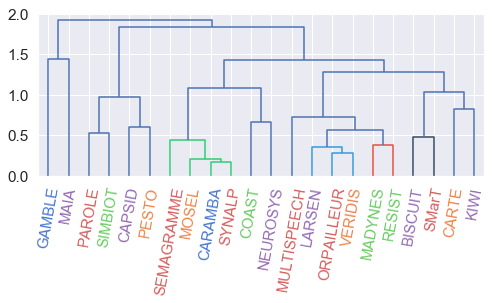

In [49]:
plt.figure(figsize=(8, 3))
hc.dendrogram(linkage_11, leaf_rotation=80, leaf_font_size=15, color_threshold=0.5, labels=res_beta11.index)
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(color_palette[depts[lbl.get_text()] - 1])
plt.savefig(OUTPUT_FIGS / 'dendro11.pdf', bbox_inches='tight')
plt.show()

In [ ]:
sns.set(font_scale=1.4)
plt.figure(figsize=(50, 50))
linkage_12 = hc.linkage(res_beta12.values, method='average')
ax = sns.clustermap(res_beta12, row_linkage=linkage_12, col_linkage=linkage_12)
for tick_label in ax.ax_heatmap.axes.get_xticklabels():
    tick_text = tick_label.get_text()
    tick_label.set_color(color_palette[depts[tick_text] - 1])
for tick_label in ax.ax_heatmap.axes.get_yticklabels():
    tick_text = tick_label.get_text()
    tick_label.set_color(color_palette[depts[tick_text] - 1])
plt.tight_layout()
plt.savefig(OUTPUT_FIGS / 'classif_12.pdf', bbox_inches='tight')
plt.savefig(OUTPUT_FIGS / 'classif_12.png', transparent=True, bbox_inches='tight')
#plt.show()

In [ ]:
sns.heatmap(pi_val_12)

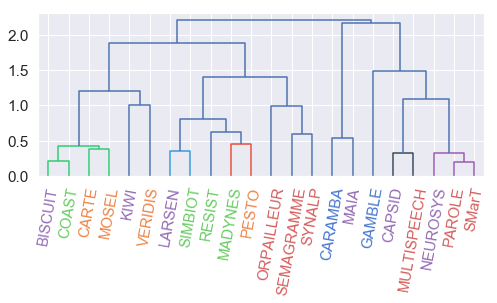

In [52]:
plt.figure(figsize=(8, 3))
hc.dendrogram(linkage_12, leaf_rotation=80, leaf_font_size=15, color_threshold=0.5, labels=res_beta12.index)
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(color_palette[depts[lbl.get_text()] - 1])
plt.savefig(OUTPUT_FIGS / 'dendro12.pdf', bbox_inches='tight')
plt.show()

In [ ]:
sns.set(font_scale=1.4)
plt.figure(figsize=(50, 50))
linkage_22 = hc.linkage(res_beta22.values, method='average')
ax = sns.clustermap(res_beta22, row_linkage=linkage_22, col_linkage=linkage_22)
for tick_label in ax.ax_heatmap.axes.get_xticklabels():
    tick_text = tick_label.get_text()
    tick_label.set_color(color_palette[depts[tick_text] - 1])
for tick_label in ax.ax_heatmap.axes.get_yticklabels():
    tick_text = tick_label.get_text()
    tick_label.set_color(color_palette[depts[tick_text] - 1])
plt.tight_layout()
plt.savefig(OUTPUT_FIGS / 'classif_22.pdf', bbox_inches='tight')
plt.savefig(OUTPUT_FIGS / 'classif_22.png', transparent=True, bbox_inches='tight')
#plt.show()

In [ ]:
sns.heatmap(pi_val_22)

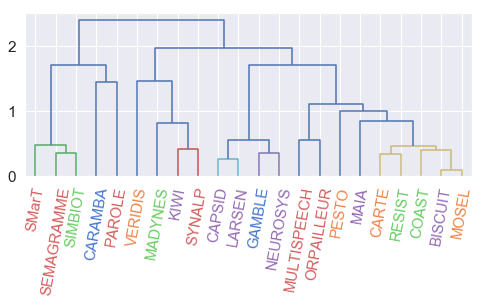

In [49]:
plt.figure(figsize=(8, 3))
hc.dendrogram(linkage_22, leaf_rotation=80, leaf_font_size=15, color_threshold=0.5, labels=res_beta22.index)
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(color_palette[depts[lbl.get_text()] - 1])
plt.savefig(OUTPUT_FIGS / 'dendro22.pdf', bbox_inches='tight')
plt.show()

In [ ]:
color_palette = sns.color_palette()
sns.palplot(color_palette[:5])

## Signifiance test : does tie are more likely to occur than pure chance ?
> Application of a T-test :

> Null hypothesis:
$\mathcal{H}_0 :  \mathbb{E}[\theta] = 0$

> Alternative hypothesis:
$\mathcal{H}_1 :  \mathbb{E}[\theta] \neq 0.$

In [38]:
sign_test = pd.DataFrame(index=list(data.keys()), columns=[r'TS($\theta_{11}, 0)$', 'p-val1', r'$TS(\theta_{12}, 0)$', 'p-val2', r'$TS(\theta_{22}, 0)$', 'p-val3'], dtype=np.float)
for k, d in data.items():
    res1, pval1 = stats.mstats.ttest_1samp(d[r'$\theta_{11}$'], 0)
    res2, pval2 = stats.mstats.ttest_1samp(d[r'$\theta_{12}$'], 0)
    res3, pval3 = stats.mstats.ttest_1samp(d[r'$\theta_{22}$'], 0)
    sign_test.loc[k] = [np.around(res1, decimals=3), pval1, np.around(res2, decimals=3), pval2, np.around(res3, decimals=3), pval3]
sign_test['p-val1'] = sign_test['p-val1'].apply(lambda x : r'$\leq 10^{-6}$' if x < 10**(-6) else np.format_float_scientific(x, precision=3))
sign_test['p-val2'] = sign_test['p-val2'].apply(lambda x : r'$\leq 10^{-6}$' if x < 10**(-6) else np.format_float_scientific(x, precision=3))
sign_test['p-val3'] = sign_test['p-val3'].apply(lambda x : r'$\leq 10^{-6}$' if x < 10**(-6) else np.format_float_scientific(x, precision=3))
sign_test.to_latex(OUTPUT_TABLES / 'student.tex', escape=False, encoding='utf-8')
sign_test

,"TS($\theta_{11}, 0)$",p-val1,"$TS(\theta_{12}, 0)$",p-val2,"$TS(\theta_{22}, 0)$",p-val3
BISCUIT,30.505,$\leq 10^{-6}$,-497.520,$\leq 10^{-6}$,-435.178,$\leq 10^{-6}$
CAPSID,204.015,$\leq 10^{-6}$,-359.185,$\leq 10^{-6}$,-466.827,$\leq 10^{-6}$
CARAMBA,-68.738,$\leq 10^{-6}$,-237.339,$\leq 10^{-6}$,-293.383,$\leq 10^{-6}$
CARTE,32.086,$\leq 10^{-6}$,-276.357,$\leq 10^{-6}$,-247.134,$\leq 10^{-6}$
COAST,-141.119,$\leq 10^{-6}$,-489.385,$\leq 10^{-6}$,-262.020,$\leq 10^{-6}$
GAMBLE,-143.234,$\leq 10^{-6}$,61.396,$\leq 10^{-6}$,-368.832,$\leq 10^{-6}$
KIWI,-24.105,$\leq 10^{-6}$,-256.393,$\leq 10^{-6}$,-305.132,$\leq 10^{-6}$
LARSEN,-77.447,$\leq 10^{-6}$,-737.265,$\leq 10^{-6}$,-355.826,$\leq 10^{-6}$
MADYNES,1.829,6.745e-02,-818.858,$\leq 10^{-6}$,-746.175,$\leq 10^{-6}$
MAIA,-431.390,$\leq 10^{-6}$,-662.307,$\leq 10^{-6}$,-187.895,$\leq 10^{-6}$


## 2D projections
> Scatter plots of estimated MAPs representing the positioning of teams with respect to the different collaborative tendencies controlled by $\theta_{01}$, $\theta_{02}$, $\theta_{12}$

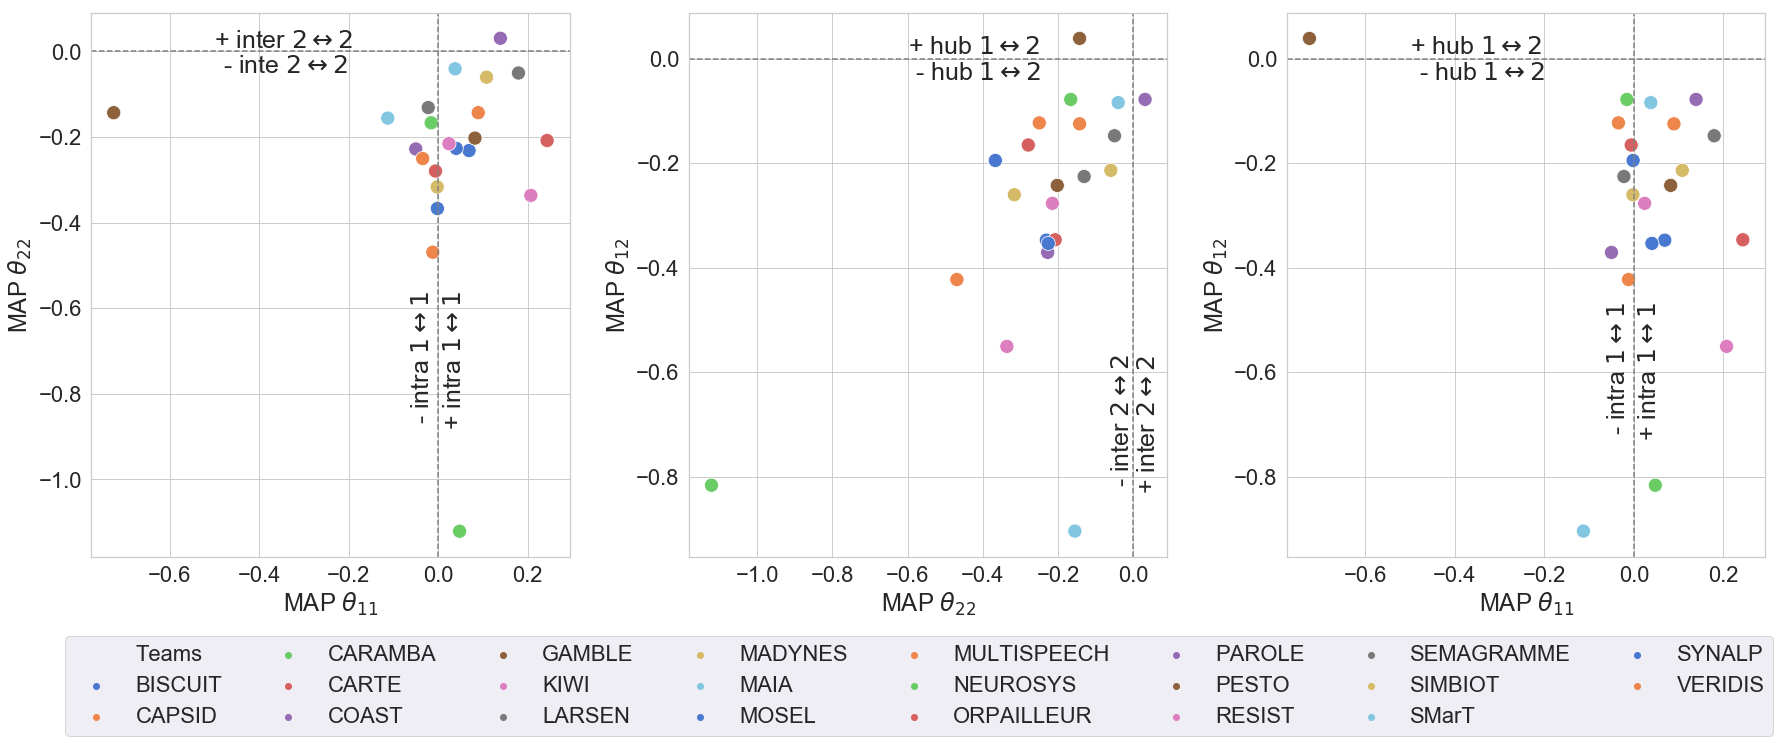

In [56]:
#sns.set_context("paper")

sns.set(font_scale=2)
sns.set_style("ticks")
sns.set_style("whitegrid")
#plt.close('all')
df_map_reset = pd.DataFrame(df_sum, columns=[r'MAP $\theta_{11}$', r'MAP $\theta_{12}$', r'MAP $\theta_{22}$'])
df_map_reset = df_map_reset.reset_index()

df_map_reset.columns = ['Teams', r'MAP $\theta_{11}$', r'MAP $\theta_{12}$', r'MAP $\theta_{22}$']

fig, ax = plt.subplots(1,3,figsize=(30,10))
sns.set(font_scale=2)
font_size = 25

ax[0].axhline(y=0, color='grey', linestyle='dashed')
ax[0].axvline(x=0, color='grey', linestyle='dashed')
ax[0].text(-0.5, 0.009, r"+ inter $2 \leftrightarrow 2$", size=font_size)
ax[0].text(-0.480 ,-0.05, r"- inte $2 \leftrightarrow 2$", size=font_size)
ax[0].text(0.01, -0.6, r"+ intra $1 \leftrightarrow 1$", rotation='vertical', size=font_size)
ax[0].text(-0.06, -0.6, r"- intra $1 \leftrightarrow 1$", rotation='vertical', size=font_size)
sns.scatterplot(ax=ax[0], x=r'MAP $\theta_{11}$', y=r'MAP $\theta_{22}$', hue='Teams', data=df_map_reset, s=200, palette="muted",legend=False)
#x = pd.DataFrame(df_map_reset[r'MAP $\theta_{01}$'])
#y = pd.DataFrame(df_map_reset[r'MAP $\theta_{02}$'])
#linear_regressor = LinearRegression() 
#linear_regressor.fit(x, y)
#Y_pred = linear_regressor.predict(x)
#ax[0].plot(df_map_reset[r'MAP $\theta_{01}$'], Y_pred)
#sns.lmplot(x=r'MAP $\theta_{01}$', y=r'MAP $\theta_{02}$', hue='Teams', data=df_map_reset, s=200, palette="muted",legend=False)
ax[1].axhline(y=0, color='grey', linestyle='dashed')
ax[1].axvline(x=0, color='grey', linestyle='dashed')
ax[1].text(-0.6, 0.009, r"+ hub $1 \leftrightarrow 2$", size=font_size)
ax[1].text(-0.580,-0.04, r"- hub $1 \leftrightarrow 2$", size=font_size)
ax[1].text(0.01, -0.60, r"+ inter $2 \leftrightarrow 2$", rotation='vertical', size=font_size)
ax[1].text(-0.06, -0.60, r"- inter $2 \leftrightarrow 2$", rotation='vertical', size=font_size)
sns.scatterplot(ax=ax[1], x=r'MAP $\theta_{22}$', y=r'MAP $\theta_{12}$', hue='Teams', data=df_map_reset, s=200,  palette="muted", legend=False)
#x = pd.DataFrame(df_map_reset[r'MAP $\theta_{02}$'])
#y = pd.DataFrame(df_map_reset[r'MAP $\theta_{12}$'])
#linear_regressor = LinearRegression() 
#linear_regressor.fit(x, y)
#Y_pred = linear_regressor.predict(x)
#ax[1].plot(df_map_reset[r'MAP $\theta_{02}$'], Y_pred)

ax[2].axhline(y=0, color='grey', linestyle='dashed')
ax[2].axvline(x=0, color='grey', linestyle='dashed')
ax[2].text(-0.5, 0.009, r"+ hub $1 \leftrightarrow 2$", size=font_size)
ax[2].text(-0.480 ,-0.04, r"- hub $1 \leftrightarrow 2$", size=font_size)
ax[2].text(0.009, -0.50, r"+ intra $1 \leftrightarrow 1$", rotation='vertical', size=font_size)
ax[2].text(-0.06, -0.50, r"- intra $1 \leftrightarrow 1$", rotation='vertical', size=font_size)
g = sns.scatterplot(ax=ax[2], x=r'MAP $\theta_{11}$', y=r'MAP $\theta_{12}$', hue='Teams', data=df_map_reset,  palette="muted", s=200)
#x = pd.DataFrame(df_map_reset[r'MAP $\theta_{01}$'])
#y = pd.DataFrame(df_map_reset[r'MAP $\theta_{12}$'])
#linear_regressor = LinearRegression() 
#linear_regressor.fit(x, y)
#Y_pred = linear_regressor.predict(x)
#ax[2].plot(df_map_reset[r'MAP $\theta_{01}$'], Y_pred)

box = g.get_position()
#g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
g.legend(loc='lower right', bbox_to_anchor=(1.04, -0.35), ncol=8)
plt.subplots_adjust(wspace = 0.25)

plt.savefig(OUTPUT_FIGS / "col_behav.pdf",  bbox_inches='tight')
plt.savefig(OUTPUT_FIGS / "col_behav.png", transparent=True, bbox_inches='tight')
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
